# Toxic comments

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Toxic comments. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [5]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [6]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [7]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(#n_features=2 ** 17, 
                               ngram_range=(1, 2), 
                               token_pattern=r'\b\w+\b', 
                               alternate_sign=False)
        X_hv = hv.fit_transform(toxic_data.comment_text)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(toxic_data.comment_text)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['punc_count'] = toxic_data['comment_text'].str.count("\.")
    toxic_data['excl_count'] = toxic_data['comment_text'].str.count('!')
    toxic_data['excl_pct'] = toxic_data['excl_count'] / toxic_data['word_count']
    
    X_quant_features = toxic_data[["word_count", "punc_count", "excl_pct"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = toxic_data['any_toxic']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [8]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='C:/Users/geoff/PycharmProjects/machine_learning_assignment1/toxic_comments/toxiccomments_train.csv', my_random_seed=19)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [9]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 13048, 'Neg': 114608, 'TP': 6500, 'TN': 57064, 'FP': 57544, 'FN': 6548, 'Accuracy': 0.49793194209437863, 'Precision': 0.10149272375242022, 'Recall': 0.4981606376456162, 'desc': 'ols_train'}


C:\Users\geoff\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


### MODEL: SVM, linear

In [10]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 13048, 'Neg': 114608, 'TP': 13035, 'TN': 114598, 'FP': 10, 'FN': 13, 'Accuracy': 0.9998198282885254, 'Precision': 0.9992334227673438, 'Recall': 0.9990036787247087, 'desc': 'svm_train'}


### MODEL: logistic regression

In [11]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 13048, 'Neg': 114608, 'TP': 13036, 'TN': 114595, 'FP': 13, 'FN': 12, 'Accuracy': 0.9998041611831798, 'Precision': 0.9990037550770174, 'Recall': 0.9990803188228081, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [12]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 13048, 'Neg': 114608, 'TP': 13047, 'TN': 113106, 'FP': 1502, 'FN': 1, 'Accuracy': 0.9882261703327693, 'Precision': 0.8967626641006254, 'Recall': 0.9999233599019006, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [13]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 13048, 'Neg': 114608, 'TP': 13034, 'TN': 114598, 'FP': 10, 'FN': 14, 'Accuracy': 0.9998119947358526, 'Precision': 0.9992333639987734, 'Recall': 0.9989270386266095, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [14]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier()
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 13048, 'Neg': 114608, 'TP': 13042, 'TN': 114598, 'FP': 10, 'FN': 6, 'Accuracy': 0.999874663157235, 'Precision': 0.9992338338951885, 'Recall': 0.9995401594114041, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [15]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

{'Pos': 13048, 'Neg': 114608, 'TP': 0, 'TN': 114608, 'FP': 0, 'FN': 13048, 'Accuracy': 0.8977878047251989, 'Precision': nan, 'Recall': 0.0, 'desc': 'rdf_train'}


C:\Users\geoff\PycharmProjects\machine_learning\ml-master\ml-master\final_assignment_1\my_measures.py:25: RuntimeWarning: invalid value encountered in longlong_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])


### ROC plot to compare performance of various models and fits

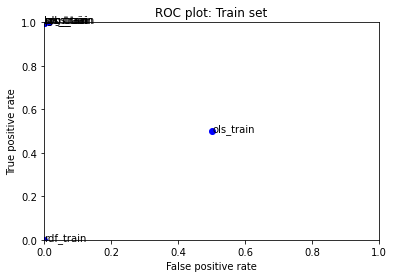

In [16]:
fits = [ols_performance_train, 
        svm_performance_train, 
        lgs_performance_train, 
        nbs_performance_train, 
        prc_performance_train, 
        rdg_performance_train, 
        rdf_performance_train
]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: Train set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

### let's look at some false positives:

In [25]:
ols_predictions = ols.predict(X_train)

In [26]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


Examples of false positives:
24
Moreover, why would you add a space, a second comma and another space after an already-existing comma in the beginning of a sentence?
* * * * * * * * * 
27
", 19 June 2014 (UTC)
 It does not follow that ""well-documented"" means it should feature ""prominently"" in this article. For the reasons I said above, article space in this article must give more weight to descriptions of anarcho-capitalism from people within the movement since this article is the only reasonable place that content (also ""well-documented"") belongs.   @  21:40"
* * * * * * * * * 
32
face. That guy doesnt even resemble Barrowman
* * * * * * * * * 
77
. by my messages says this message are don't making sense, so me are likely to sense
* * * * * * * * * 
215
That should be easy - I'll email you when I have something to show. –
* * * * * * * * * 
238
"

""Muslim""
The word Muslim certainly appeared in the article, because the victims were primarily of that religion. The term was edite

2592
Restaurant Notability  

A formalized vote has begun regarding notability and your input is desired, thank you ) -
* * * * * * * * * 
2735
"15 October 2006 (UTC)

Your blanking of Attack on Pearl Harbor
Please do not replace Wikipedia pages with blank content, as you did to Attack on Pearl Harbor. It is considered vandalism. Please use the sandbox for any other tests you want to do. Take a look at the welcome page if you would like to learn more about contributing to our encyclopedia. Thanks.    (talk) (contribs) "
* * * * * * * * * 
2785
Wei, why u delete my post? Alibaba is really a character lar. Alamak....... You no belief me u go c google. I sure u can find lot of info bout the alibaba character OKAY?...
* * * * * * * * * 
2865
"Held
!style=""background: #e3e3e3;""|Date Won
!style=""background: #e3e3e3;""|Date Ended
|-
|"
* * * * * * * * * 
2876
"

""Camel toe"" (with a space!) is the accepted short-hand for this topic. See Partridge's ""dictionary of modern American slang an

5993
i found it a few minutes ago.
* * * * * * * * * 
6012
About the 5.45 x 39 mm article 

If you disagree on something you can use the Discussion page and let the people decide. Until then, you DO NOT delete anything.
* * * * * * * * * 
6018
(UTC)

Agreed.  This article is becoming quite the convoluted mess.  (Talk:キュウ) 19:56, 5 August 2011
* * * * * * * * * 
6063
"
GoodDay, the countries category is called just that, not 'Independant countries'. Wales, Scotland and England are countries (NI is not, but that's another matter). As they are countries they belong in the countries category, perfectly logically. In any case, this has been discussed repeatedly and the consensus is - as if we needed to be told! - that they are countries. Despite my opposition to the inclusion of the Six Counties - English Wikipedia has followed the political line of the New Labour UK government, a lie line which is contrary to the Belfast Agreement - I am tempted to agree with the compromise 'Category:Count

9166
":Sorry for such late reply, while not on wikibreak exactly, I've been busy enough in real life I haven't done any editing that takes time, as your question deserves.  I think the biggest issue with the article is that it makes no claim of notability.  Why does it stand out?  Why is it worth an encyclopedia article.  Please see WP:NOT and particularly WP:NOTDIR.  Although the article isn't the worst offender on promotion by any means, it still looks to be promoting services.  Read the other reviewer's comments, they are very valuable.  All the best,  (I'm no IP, talk to me!) 

"
* * * * * * * * * 
9221
with ties to the NDP and to a cabinet minister
* * * * * * * * * 
9313
And THAT's my last post.  WilliamH, sorry for wasting your time.  Everyone else, search 'antisemite vs. truck' on the YT in a few days.
* * * * * * * * * 
9394
"

 November 2007 

(See the history of this talkpage for all previous warnings recieved on the 6th November 2007, but which were deleted by the IP)

 dra

13726
Jacob ebbs 
Hello and welcome to Wikipedia.  An article you recently created, Jacob ebbs, has been tagged for speedy deletion because its content is clearly written to promote a company, product, or service.  This article may have been deleted by the time you see this message.  Please keep in mind that Wikipedia is an encyclopedia, not an advertising service.  Thank you.
* * * * * * * * * 
13769
Support. 'America' usually refers to the United States, and is different from 'the Americas' (which refers to North and South America).
* * * * * * * * * 
13802
November 2009 (UTC)

The context is evident in the movie, so we can understand her comments as true.   22:20, 25
* * * * * * * * * 
13826
Here's *THE LATIN* reference, the Lewis and Short Lexicon [with minor correction from my hardcopy]:
http://www.perseus.tufts.edu/cgi-bin/ptext?doc=Perseus%3Atext%3A1999.04.0059%3Aentry%3D%2319181
G , g , indecl. n. or (on account of littera) f., had originally no place in the Latin alphabet: bot

17220
I agree with TenOfAllTrades that Brews's own talk page wasn't a really appropriate place to put the advice, which was the exact reason why I put my (already removed) remark elsewhere, but it was the only place where one could effectively reach everyone involved. Someone had to do it, so to speak. Like I predicted, I wouldn't work -| -
* * * * * * * * * 
17231
I think we should do just that. Although I dont know if it would work since all past disputes relating to Gibraltar seem to have died down since editors have desisted arguing with Gibnews. 
Independent opinions would have to look at the whole discussion page. I have looked at it recently and it basically consists of Gibnews imposing his will on a number of other editors relating to many issues. Some of them are as silly as whether the disputed tag should be included on the article...(Gibnews thought it shouldnt even though his version was disputed by all other users) 
Who was in control of the Kosovo page? Was it a pro-serb 

21104
He was a writer on the man show yet this is neglected here...
* * * * * * * * * 
21236
book reference 

Hi Michael. We need an admin on book reference. You also voted on Template talk:Book reference#Request to switch back to using qif to revert to the qif variant. I think there is clear consensus to do so (Ignore Phil for now, he is also for the qif variant but seems to have a some strange nasty idea for a change, but there is no reason to wait any longer). Please edit template:book reference and revert to  http://en.wikipedia.org/w/index.php?title=Template:Book_reference&oldid;=35664787. If I had the mop and the bucket I would do it myself without hesitation. WP:AUM is gone and Neto lost its license to terror us with WP:AUM. qif is the best we have for now and it produces decent html. In the long run  that will be implemented in MediaWiki anyway, possibly with an intermediate step having conditional logic in MediaWiki. Thank you. Adrian Buehlmann
* * * * * * * * * 
21243
about t

24534
Please don't spread any lies. I removed the request from WP:RM, where I had originally placed it following discussion on this talk page, only after the page was moved — and not by me. Besides, your apparent disagreement with a previous page move does not warrant a page move to the previous location without discussion. If you'd care to look up the Netherlands in other source material, you'd find that the name of the country is THE Netherlands, not Netherlands.  10:26, 23 Mar 2005 (UTC)
* * * * * * * * * 
24658
Finally, must reports that are released from accident investigators have a list of recommendations for changes in training(that is the reason why they have an investigation)
* * * * * * * * * 
24782
Cka4004, the reason why Guilherme Paula provided the code for the infobox is because of this Talk:Northern_Ireland#Short_term_fix discussion. It wasn't so that we could restart the whole discussion again fron last October, the concencus is to remove all flags from the infobox, th

27951
Neither are objective editors, and both have a pov, and agenda.
* * * * * * * * * 
27990
Thanks.  Is this a 156 seater?
* * * * * * * * * 
27994
" 

Hornet Mafia, Article Deletion Nomination

Hell, this term even appears on this Wikipedia discussion page.

An article has been created defining this term, and subsequently nominated for deletion by purists who have identified him/themselves there.  If you believe that the concept ""Hornet Mafia"" is as real as ""UFO sighting"", or if you believe that WP should not have an article for anything that isn't the the Brittanica, please participate at Wikipedia:Articles for deletion/Hornet Mafia  "
* * * * * * * * * 
28025
leave it on what we agreed on, or I will have to put my own neutral phrase in. deal.
* * * * * * * * * 
28077
I don't see any uncivil comments above.  Talk
* * * * * * * * * 
28090
2012 (UTC)
 Who says you can't say that? Try it out. No seriously, try it. If prestige is perceived as much 'a part' of a career in law as pr

30922
The last info that I added was verified!  

Apple has started seeding the new beta of OSX10.6! Why did you delete it? I quoted it!
* * * * * * * * * 
30938
Does anyone have any photos of Holland Park to put on the page?
* * * * * * * * * 
30951
John Lennon? 
The promoters of Woodstock refused John Lennon? Any reason why? Sure, it would have been nice if the Beatles had been at Woodstock, but why refuse Lennon?-10/4/06
* * * * * * * * * 
30964
Who are you, could you tell me? 

First let me know who are you, where from and why are you editing Salim Saifullah's Page?

I surely need help by you.
* * * * * * * * * 
30971
replied on your talk page
* * * * * * * * * 
30995
I see. So just because WWE says something in their title history, doesn't mean it's correct. Right??????
* * * * * * * * * 
31003
If I am not unblocked within 24 hours I will not be returning to Wikipedia. This is an absolute joke.  talk
* * * * * * * * * 
31084
efforts for the gay community keep it up man.
* * * * * 

34521
Of course it deserves a mention, The Big Bang Theory made this restaurant famous. It's the reason I came to this article. But obviously this article is compromised by a partisan who sees the association with The Big Bang Theory as negative publicity. This is exactly why Wikipedia can never be a reliable source and it's shameful.
* * * * * * * * * 
34612
Well, the Altiyan Childs picture was on Facebook, so it's there for everyone.
* * * * * * * * * 
34614
"""It seems that there are repeated attempts to use this page as an advertising platform for Call/Recall. Could anyone with experience in such matters advise on appropriate action to take? TheBendster ""

Retrieved from ""http://en.wikipedia.org/wiki/Talk:Two-Photon_3-D_Optical_Data_Storage""

Dear Bendster,
Isn't this a little bit of the pot calling the kettle black?  It seems you've been doing the same thing for your own ends.  This is not an advertising forum, there is nothing but facts there relating to Call/Recall.  (Unsigne

37968
"
Welcome to Wikipedia! We welcome your help to create new content, but your recent additions (such as Bikini Bottom-Goo Lagoon) are considered nonsense. Please refrain from creating nonsense articles. If you want to test things out, edit the sandbox instead. Take a look at the welcome page if you would like to learn more about contributing to our encyclopedia.   talk|contribs "
* * * * * * * * * 
38025
Have were unconstructive because it was the either May 5 or 6. Those were my bad days. But look at the other ones. Maybe only Toronto Raptors and it was a test by a new users and accourding to your policy, it is not vandalism. I made good edits to Lamar, point guard, Tracy Mcgrady and much more. Can't you just look at those and give me asecond chance and I will only make positive edits.
* * * * * * * * * 
38099
"

Hi sorry to hear about the wesbite for you too. I did manage to add villages to one earler but when I tried the next municipality it froze again. I'm sure you can access

39923
Arenas & St.Patricks captains
Does anyone have a list of the Arenas & St.Patricks captains? If so, could you add it to the article?
* * * * * * * * * 
39936
"

 HELP ME PLEASE I am now mad...I need to calm down 

mmmm..yes and now I am typing so fast it's going to spew out like a fishery in a door mat postal service.

Creating a new article is a fucking doodle...not...it took me two hours to read through various information and put in biographies and shit for Corpsefucking Art. and what do THEY do? fucking facists deleted in within 2 secs.

I saved it...and this is what I got...change the stuff with me...help...before I like FUCK THEM UP WITH ANOTHER POEM.

so far...

CorpseFucking Art (C.F.A.) are an Brutal Death Metal/ deathgrind band, from  Italy formed in 1993. Their lyrics focuses mainly on gore and Humor.

Biography

The band was formed in Rome in 1993. With the first line-up (Max - gurgling, Andrea - guitars, Fabio - bass, Marco - drums) under a different name Enthralment 

41201
"
OK I think I've done it right - please let me know if I haven't. Also, do you know how to edit the bit right at the bottom of the Sealand article that shows up as {{sealand}} in the code? 01:39, 2 Jan 2005 (UTC)
Yes, that looks fine. To edit the footer, you have to go to Template:Sealand and edit that. Under the edit box there's a list of links to the templates in use on the page you're editing. * 01:42, 2005 Jan 2 (UTC)"
* * * * * * * * * 
41228
Its in the NW in NSW Schools Rugby League.  Thats enough of a qualifier.
* * * * * * * * * 
41254
"

 Vandalism by 99.44.204.232. Please stop it  

Would 99.44.204.232 stop vandalising this article.  People have invested a lot of time and effort to improve this article  it doesn't help if you keep vandalising it.  In future if you have something positive to add to this article please discuss it in the talk page.  I have to spend hours undoing what you have just done.  Citing several sources (some of which are unreliable) about one part

41861
, was it perhaps random? Gothaparduskerialldrapolatkh
* * * * * * * * * 
41907
The article is written in neutral language. It was sourced from all relevant and known news media available. If you can add more reference material I would be interested in seeing it.
* * * * * * * * * 
41990
"

 Please do not vandalize pages, as you did with this edit to Richard Sandrak. If you continue to do so, you will be blocked from editing.   "
* * * * * * * * * 
41996
The section is already overly detailed, as is. Please also remember to observe [{WP:BRD]]. If you add new material to an article and it is questioned, it is better to actually discuss it either on user talk or on the article talk rather than just continuing to add it over and over.
* * * * * * * * * 
41998
Answered on my talk page (where you cross-posted this).
* * * * * * * * * 
42028
Looks fine. No worries. ) ''''''
* * * * * * * * * 
42063
Dude i realy don't care what you say that guy is unfair and not cool.
* * * * * * * * * 


43481
"

 ""I have no tribunal"" 

Revision on ""Is my verse alive""

This helps to counter the ""woman-child"" image (Wolff) that clings to this section and add a dimension of what Adrienne Rich called ""a figure of powerful will, not at all frail or breathless. She's talking about ED, you see.Mysweetoldetc. "
* * * * * * * * * 
43538
"
See my response at the article's talk page. No sense in two parallel discussions. Makes my fingers tired. Ħ  "
* * * * * * * * * 
43567
We do apologize for the mistake of deleting material on someone else's talk page. As far as we know, there was no page associated with the David Pettersen that we know - and he has also informed us that he has never had a page on Wikipedia before, to his knowledge.
* * * * * * * * * 
43596
And I am undoing you edit. I am trying to have a discussion on improving the Sarah Palin page and what material to include or not include.   Bits andPieces
* * * * * * * * * 
43621
Please do not remove content from Wikipedia. It is c

45067
"

Scarlet may indeed be on her way to notability; page me again in five years, but I don't think she's there yet. As for Yoji, his support seems to confuse the demand for over-the-counter legal softcore kiddyporn with his notability as a photographer of same. Oh well, anything goes at WP, I s'pose, as long as it's related to ""popular culture"". (Incidentally, did you see the recent comment on Bobby's talk page?)   "
* * * * * * * * * 
45206
Semi-protected edit request on 15 March 2015 

221.193.194.176
* * * * * * * * * 
45215
"

Do you see your own contradiction above? Here are the rules ""there is no criticism to Cynefin>>> therefore no criticism allowed on Wiki >>> try to publish criticism in a refereed journal >>> by the way no respectable journal would ever entertain the advancement or criticism of Cynefin, but HBR will advance it!"""
* * * * * * * * * 
45228
I promise not to mess up user talk pages, I only will get a Wikipedia account.
* * * * * * * * * 
45270
"

 More de

45873
"

 The national motto of Turkey 

Our national motto is ""Yurtta Barış, Dünyada Barış"" which translates to ""Peace at home, peace in the world"" 

This motto used to be present on the article but has thenceforth been removed. It is a key motto in Turkey's modern self and the reader would benefit greatly from knowing this motto when wanting to learn about Turkey"
* * * * * * * * * 
45894
GOOD RIDDANCE. GET LOST.
* * * * * * * * * 
45920
":""Please tag your ID's""? Excuse me? As you might guess, the people writing here may have been at the NUS and therefore experienced it and thus claim certain aspects of this wikipedia entry as 'propaganda'. Do you think anyone would want to have an ID tag with such an 'accusation' in place? - I think not, especially as it is so obvious that the biased POV provided in this article reflects the interest of the NUS itself and it is up to the reader to assume who added this sort of content. - I am very dissatisfied with the level of quality in this

47326
You know what else?  Because of the same type of bias that the guy is displaying, media reports are frequently biased.  It's like a bias echo chamber.  They write biased articles, then they come here and use Wikipedia to trumpet them. Clever, really, but unfair and untruthful.
* * * * * * * * * 
47355
Thank you Poeticbent for a very lucid and rationale explanation. Seems logical to boot. And Balcer, your point seems less so. I suppose to follow your explanation with the consistency one would expect in an encyclopedia, we would have to call Krakow, Cracow in any reference to the city prior to 1975.
* * * * * * * * * 
47363
I was pointed at this by a request by Thunderer for more eyes on the article on AE. As for the consensus for creating a criticism article, Thunderer asked for more eyes on the article at the Military project sub-article, who indicated that the article was getting too big, and suggested creating sub pages for some of the larger sections. I happen to agree with it

49726
Wikipedia meetup:Tampa
I'm writing to let you know that the Tampa meetup has officially been announced  Wikipedia:Meetup/Tampa2
* * * * * * * * * 
49766
The meat of this matter is your failure to engage  in meaningful WP:BRD at the article talk page.  Please delete the bloggish entries related to your dispute with him and instead start discussing at the article talk page.  I have left him a similar note.
* * * * * * * * * 
49785
The same applies to your latest revert at National Basketball Association. Just wait for consensus when there is a an ongoing discussion. Thanks.—
* * * * * * * * * 
49832
Surfing Pikachu 

I noticed that the surfing Pikachu was mentioned in a bunch of different places, and most of them out of them out of context. I think we should stick to the one section about it, and leave it at that.
* * * * * * * * * 
49859
"

...which is the reason why I first discuss it, then change it.  An edit war is nothing pretty, you  know?  We'll see.  Anyway, what you write 

A section on games that can beatable if you have an edge like hole carding is a good idea.  Then we can get rid of the normally non-beatable games that some editors have insisted are beatable theoretically.  It could be a good idea before adding such a section to put it first on this talk page.
* * * * * * * * * 
50681
"

Oh now I realize: you're the same anon who was causing trouble at SHAC. You seem to have an axe to grind.  (talk) "
* * * * * * * * * 
50730
"

Dear Modernist - 

Thanks for the clarification; the Stalinist nomenclature is puzzling. But here's one more detail on the citation:

Citation 23 at http://www.xtimeline.com/evt/view.aspx?id=15752, states that that Picasso recieved the ""Lenin Peace Prize"" in 1961, but is reported in the Picasso text as 1962.

The Wiki source, at http://en.wikipedia.org/wiki/Lenin_Peace_Prize, says 1962 (""International Lenin Prize""). Can we use our wiki site as a source, or is that considered bad form?

I'm also adding a brief quotation fro

52594
"''' on your talk page and ask your question there. Please remember to sign your name on talk pages by clicking  or using four tildes (~~~~); this will automatically produce your name and the date. Finally, please do your best to always fill in the edit summary field. Below are some useful links to facilitate your involvement. Happy editing! ~Kylu (|t)  
|}
{| width=""100%"" style=""background-color:#F5FFFA;""
|style=""width: 55%; border:1px solid #FFFFFF; background-color:#F5FFFA; vertical-align:top""|
 Getting started Wikipedia tutorial • The five pillars of Wikipedia • Getting mentored
 How to: edit a page • upload and use images Getting help Frequently asked questions • Tips
 Where to ask questions or make comments
 Request administrator attention Policies and guidelines Neutral point of view • No original research 
 Verifiability • Reliable sources • Citing sources
 What Wikipedia is not • Biographies of living persons

 Manual of Style • Three-revert rule • Sock puppetry
 C

56466
Tanakh / Torah / Old Testament 
I noticed you had difficulty accepting category additions of Old Testament on several biblical articles.  For Christians we do not call it the Torah or the Tanakh.  Many Christians would not know what these words mean.  For those who do not follow those names I was placing categories that would make sense to Christians.  This was for navigation purposes.  I see no problem in having the additional categories.  
I also noticed that you might you might be considering my changes vandalism.  It is unfortunate that you would think that.  My efforts are pure and true and I don't see how any of my changes could be vandalism.  It was my understanding that Wikipedia was meant for all people of all faiths and understandings.  By not allowing Christians the proper category to navigate through articles you are denying us that privilege.

Thank you for you time.
* * * * * * * * * 
56484
I ran across it because of image issues on Commons. I think it's spam by a n

60030
make mention of comment and you are party to said comment? ridiculously circuitous route to whitewashing. events from comment out do not impact preceding events.
* * * * * * * * * 
60195
"

Please stop. If you continue to vandalize pages, as you did to Hello!, you will be blocked from editing Wikipedia.   talk  "
* * * * * * * * * 
60200
How in the world is that statement worthy of a two day block? TreasuryTag files a misleading, half-complete WQA (after a day's worth of baiting and smiling incivility) and when I respond, I get blocked? Are you kidding me?
* * * * * * * * * 
60211
, first is in relation to Quiver_(mathematics) usage.
* * * * * * * * * 
60220
"20, 15 April 2008 (UTC)
It's a quote from Jimbo Wales   
Ha, as if anyone takes notice of this! I would be deleting content 24/7 if this was a policy. I add {{fact}} because several times as soon as I deleted the content was re-added immediately, still without citation. However, I think that in stubs citations are not crucia

62748
":The government is not a reliable source.  talk 

"
* * * * * * * * * 
62852
Can I put brackets then?  Why do you insist this be here?
* * * * * * * * * 
62875
find something I edited reverted, then I will resolve the issue in a mature manner and not start and edit war or abuse a fellow wikipedia member. I do
* * * * * * * * * 
62962
"

My point exactly!!  

berlet is adding extensive unsourced original research

Cberlet is adding extensive orginal research and wildly POV assertions regarding his 20 year old claims that simply are not borne out by the references. All assertions to the effect that ""Berlet subsequently found out the evil cultists were lying"" that are not references are simply self serving original research and are being removed unless berlet can find a reference to support the claim. As well, the angry POV tone of Berlet's edits are being removed, and I suggest cberlet not use an encyclopedia entry as a vehicle for angry OR POV statements.

As to the response fr

66054
I don't need to know that. The cabal can prosecute without me being involved. I know your ways, cabal.
* * * * * * * * * 
66110
"I just read this article for the first time yesterday and I agree that the language in this article is not encyclopedic in tone. It made me laugh out loud in several places, and it's probably not supposed to. Even if the sources use this kind of language, it is not considered the best writing practices and can be vastly improved. For example,

 Why would Nelson's legitimate children be singled out in a box? Why in the section titled ""Children"", would the ones sired out of wedlock not be included, as in the one he had with Georgeanne Crewe? Why actually have an entire section on his children? Why not just a paragraph? Or actually, they are mentioned in other places, so why the entire section to emphasize them? 
 Why is Kris Nelson described as ""making love"" with Ron Reagan, but Nelson is described as ""cavorting"" with two LA Rams cheerleaders in the

69599
Perhaps there should be an external link from the Human_Rights_and_Equal_Opportunity_Commission page to your writings in order to demonstrate a great example of the sort of comment that promotes racial and religious intollerance? Do you have any strong feelings either way regarding External links?
* * * * * * * * * 
69617
"

Signing comments
Please sign your comments with four tildes (~), not three. Thanks. –projectors– "
* * * * * * * * * 
69811
Then grow up and stop spamming on my page.  I hear your mommy calling.  Run along.
* * * * * * * * * 
69821
"No not at all. There is nothing about my work since 1975. It still says I filed a patent application, which is not true. It does not mention that I gave up on that particular FTL design in 1991. It does not mention that I predicted the SUPER SOLID before Tony Leggett did. That is major. It does not mention most of my mainstream papers. All of that info and more was vandalized from the article by my enemies.

All that ""kook"" stuf

72749
unblock|I'm twelve! What is this?
* * * * * * * * * 
72922
Thanks for the welcome
I only now noticed your welcome text. I can't say I'm an active participant (made only one article in the Dutch wikipedia).  I just put up a help question in my user page that is more a question from the readers perspective I suppose.
* * * * * * * * * 
72996
Hello, Foodog5, and welcome to Wikipedia! Thank you for your contributions, especially what you did for Tablet computer. I hope you like the place and decide to stay. Here are a few links to pages you might find helpful:
 Getting started
 Introduction to Wikipedia
 The five pillars of Wikipedia
 How to edit a page and How to develop articles
 How to create your first article 
 Simplified Manual of Style
Please remember to sign your messages on talk pages by typing four tildes (~~~~); this will automatically insert your username and the date. If you need help, check out Wikipedia:Questions, ask me on my talk page, or ask your question on this pa

76210
"
The entry ""San Marino"" provides a special reference. See ibid. p. 169.   "
* * * * * * * * * 
76262
"

Test
Candid Camera: Australian Photography 1950s–1970s was a group retrospective exhibition of social documentary photography held at the Art Gallery of South Australia from 28 May to 1 August 2010.Art Gallery of South Australia Exhibitions Candid Camera website

Candid Camera had its roots in Six Photographers, a groundbreaking exhibition held in Sydney in May 1955, which concentrated on what was still a relatively new development in Australian photography and featured the work of Max Dupain, David Potts, Axel Poignant, Gordon Andrews, Kerry Dundas and Hal Missingham.Robinson, Julie ""Candid Camera: Australian Photography 1950s–1970s"" Art Gallery of South Australia exhibition catalogMcDonald, Patrick ""The Way We Were"" The Advertiser, 20 May 2010 AdelaideNow websiteNewton, Gael ""Shades Of Light: Photography And Australia 1839-1988"" Collins Australia, 1988 (ISBN 07322240

80899
looked like vandalism but probably wasn't—and failed dismally
* * * * * * * * * 
80982
new channel for KUVM-LD 

Joe, did you rescan for KUVM-LD?

They moved from RF-40 to RF-22

Why are they IDing as channel 10, instead of the RF channel for channel 22, which is on channel 47, well they should of IDing as channel 48

When will we have a PISP of 35, I think channel 28 should need to move to the channel 40 frequency

like Jose Jose says 40 y 15

While channel 53 should move to the channel 28 frequency
* * * * * * * * * 
80992
An eye for an eye is the only true justice, and I do not trust Wikipedia's standard procedure. It is a broken, anti-Semitic failure of a Web site.
* * * * * * * * * 
81021
You say that England does not have a national anthem of its own?!?  You obviously don't live in England!
* * * * * * * * * 
81050
Do not delete warnings from your usertalk page, this may result in your user account being suspended. 85.237.211.189
* * * * * * * * * 
81114
I see updated one m

84464
"

 Please do not vandalize pages, as you did with this edit to Shield volcano. If you continue to do so, you will be blocked from editing.  '''' Lets talk! "
* * * * * * * * * 
84466
Look sorry if I offended you. I was just joking around. I didn't realize that you would take it so seriously.

-wrosew
* * * * * * * * * 
84527
You are simply out of real excuses to revert me so you use beurocracy.
* * * * * * * * * 
84607
"do you know difference between words ""identical"" and ""similar""? thanks!

"
* * * * * * * * * 
84632
"

Chris Daly Part Trois
A reply to the message you left on my ""talk"" page (if everyone calls them ""talk"" pages, then why does the tab always say ""discussion""?):

Well, first of all, it's not my ""personal summary""; I didn't even write the paraphrase. But the salient point is that certain editors feel there's something sacrosanct about the M&R; quote, which is ludicrous. This is not a public official being quoted, nor a well-known source, but a couple of

88819
I have addressed the problem by explicitly naming the five sources that represent this view.
* * * * * * * * * 
88822
Assessment 

Article given stub class as other wikiprojects have identified this article as being a stub class article.
* * * * * * * * * 
88837
I will start on Mokshada Ekadashi and Kamada Ekadashi soon.
* * * * * * * * * 
88915
No and yes.  There really was nothing useful there to restore.  Just two external links to the sf.goarch.org site.  OTOH, if you think that he meets the notability requirements, you are more than welcome to construct a brand new article. -
* * * * * * * * * 
88971
You guys may remember a few months back someone wrote to the Teahouse and asked if there was a Christian bias to Wikipedia.  She was somewhat a crackpot, but Dennis, I think, wrote her a nice note stating, among other things , that Teahouse may just attract more Christian users because of the Christian credo of being helpful.  Methinks he may be right.
* * * * * * * * * 
89003
"

93299
WGHN-FM talk page
Were you the deleting administrator for the WGHN-FM talk page? I have split WGHN into WGHN (AM) & WGHN-FM as the stations haven't simulcast in years. I need the talk page undeleted.
* * * * * * * * * 
93305
"

2008
WikiProject Birds June 2008 Newsletter
The June 2008 issue of the Bird WikiProject newsletter has been published.  You may read the newsletter, change the format in which future issues will be delivered to you, or unsubscribe from this notification by following the link.  Thank you.This has been an automated delivery by   

 Spider webs in space 

As per the talk page of spider webs in space, i am considering merging the article into spider web. I saw you had considerable objection towards the previous merge, so i decided to inform you here so you could input. Best,   

 The Military history WikiProject Newsletter  Issue XXVII (May 2008) 
The May 2008 issue of the Military history WikiProject newsletter has been published.  You may read the newsletter

95982
, although if you want to cite a reference you could add a remark about the existence of this criticism
* * * * * * * * * 
96051
Wrong.  You need to transfer to the Navy to go to BUD/S.
* * * * * * * * * 
96052
To Rosicrucian
Don't lie about me. I see an edit conflict up above, and I can tell the servers screwed up because I never saw an edit conflict warning, and I NEVER deliberately removed Tariq's statement above, even though he's blatantly violating policy by coming in like he did on it.
* * * * * * * * * 
96102
"
No need to have redirects as no one is likely to search these titles. Maybe just delete all as CSD A8? o5 "
* * * * * * * * * 
96127
"

If CNN,CBS and Hollywood belongs to us, we will be stereotyped also...It was also limited the immigrants who came from asian and mediterranean countries too...Dont you heard that? I didn't suprised, actually.You've grown up there.Here is not said ""Talat Pasha hates Armenians"" right as well.  "
* * * * * * * * * 
96141
South Dakota

99103
"
Greg, have just copy-edited the quote in that footnote and in ""Criticism"" (punctuation & format) and got to thinking about the word ""sacrifice"".  It struck me as a bit odd first time round, and have just seen it is your paraphrase of the Independent report.  (I assume that was your edit in ""Criticism"".)  Do you think the uninformed reader will understand what is meant by ""sacrifice"" in that context, i.e. that true jihadists sacrifice their own lives in the pursuit of jihad?  I was wondering if ""actions"" (the Independent's word) or some other word might be better, or if  the passage in ""Criticism"" should be expanded to explain ""sacrifice"".  If you think the word is okay and readers will pick it up from the quote anyway, that's fine, although I can't imagine readers look up all the citations. Do you see what I mean?  Horrors, I hope some admin doesn't think I'm canvassing an edit! Perhaps this should be on the Talk page.   "
* * * * * * * * * 
99187
The person who d

102239
Please stop adding nonsense to Wikipedia. It is considered vandalism. If you would like to experiment, use the sandbox. Thank you.  2000
* * * * * * * * * 
102243
Family Structures 

Is there any good historical data that can be added for this section ? Can we find anything about average family size,relations, etc.
I find it ridiculous that 90% of the info in the section is about gay marriage and abortion. What are they trying to say ?
* * * * * * * * * 
102285
youre an extremist striver, stop trying to pov this article. wikipedias not a place where you get to push your more jews need to be in ovens pov.
* * * * * * * * * 
102307
"you can find more info on this at http://en.wikipedia.org/wiki/Nietzsche_Music_Project supposedly he felt that his composition ""Hymn to life"" should be listened to in order to properly interpret his work.  but I haven't heard it and feel like ive done a good job grasping his ideas..

"
* * * * * * * * * 
102335
It's a magazine called Adventures. It's

106643
Hello 

Hello, Deco, just decided to leave a message on your talk page.. I must say, looking at your User Page, you appear to be an expert on programming and code P .. I'm not too good at it, even a bit of wiki-code I cannot understand P .. Anyway, in our chat in IRC, you said you were a member of many wikipedia languages, so (this is JUST an idea, friendly advice), perhaps you should add like [[es:User:Illyria05]] to the bottom, so people who wander around (like me) on different wikipedias can see what wikipedias you are associated to.. Again, just some friendly advice... ) Leave me a message on my talk page if you want..  (Talk • Contributions)
* * * * * * * * * 
106648
Something 

Look Renzoy16 I'm Sorry for attacking you you are the great editor in wikipedia.
* * * * * * * * * 
106659
"
Done! And thanks for pointing that page out to me, I was going change it back anyway, it was a bit distracting.  
No problem!  "
* * * * * * * * * 
106679
Agree. And there's no reason why we 

108011
"

 No, I don't think so. ""Shuvat Rachel"" is an illegal Israeli settlement project in the Palestinian West Bank. Hamas affiliates have nothing to do with the international jihadi elements that are so prominently featured in that category. 
 You can file the attack under ""nationalistic terrorism"" if that gets you off but it's fundamentally wrong to characterize Hamas as being motivated through conservative Islamism.   "
* * * * * * * * * 
108017
Where can I read the vandalism site? Please tell me! Thank you!
* * * * * * * * * 
108068
"
  Sorry, but the above website is not at all a WP:RS, and as such the article should not link to it.  (talk|contribs)  "
* * * * * * * * * 
108093
Scorpio in Chasm City?

Where does Scorp show up in the Chasm City novel? I don't remember him at all (I know there's a random pig with a crossbow, but that doesn't mean it's scorp).
* * * * * * * * * 
108099
Request for comment: Wikipedia article on Pottery

This dispute is concerned with definition

109563
BuddhaInside, refusing to communicate with other users on your talk page by consitently blanking it is not in the spirit of Wikiquette and WikiLove, which are fundamental concepts of the Wikipedia community. Nor is your behavior on the silly List of heterosexuals. You are welcome to make contributions to Wikipedia, but if you continue with your current trolling, it is likely that you will end up being banned. Please focus on useful contributions instead of alienating other contributors. Thank you! Note that this page might be protected if you continue to blank it, to guarantee that at least these messages are a matter of public record. 00:45, Sep 7, 2003 (UTC)
* * * * * * * * * 
109578
Good find, thanks! I look forward to reading both the for and against in detail.
* * * * * * * * * 
109641
Pók-spider, ember-man (both male and female).
* * * * * * * * * 
109725
OK, Steve, to be honest I really like the present form. So, I don't have any issue with the present one.
* * * * * * * 

110993
I never edited the content of your comments, please correct your false accusation.
* * * * * * * * * 
111006
")

 I'm sure someone would be just thrilled to delete the number of /tmp pages which would be involved in the many articles without full citations.  What is the ""this whole problem""?  What are the ""both cases""?  I've been involved with Cite before it was installed here, but how does yet another format do more than offer another format not to ""convert""?  ( "
* * * * * * * * * 
111112
"

I'm a student at Woking College and I've forgotten the password to my account (Annon O'Mous).  I can't request a new password  due to the IP Block.  The page I wanted to edit was the main page for ""Negima"".  I wanted to put information up about who publishes the Negima! Magister Negi Magi books here in the UK.  Also, I noticed that the time and date of the IP Ban keeps updating to the present time and I was wondering if this is normal and is the result of an indefinate IP ban or a 

111799
There are plenty of sources which are not age old and I have provided them before considering I used to take part in actual discussion on discussion pages until DIREKTOR would then find a way to limit that discussion in that the discussion page is 'not a forum'. He is against any academic progress and democracy in general. Stating such is; of course, an attack on his character even though he openly worships communist totalitarian regimes here on wikipedia and communist totalitarian dictatorships and dictators. Even when there is vast consensus against him, since he is paid to be here, he knows every possible way to limit such exposure and simply logs complaints against the opposition until they are completely outlawed and banned. Typically this type of behavior is traditional in communist totalitarian dictatorships. My comment was of course a legitimate content comment as all content is monitored and approved by DIREKTOR and his lobby group here on wikipedia. Unless you have som

113227
All of the following Wikipedia pages refer to sales results and market share: Windows_Mobile, Windows 7, Kinect, XBox, Hotmail, Microsoft_Office, which brings into serious question the motives of those who've been repeatedly deleting sales information from this page! Is it the last gasp of a dying despot? 174.24.251.218
* * * * * * * * * 
113250
That is not a personal attack; it is a warning. I was merely stating fact, when I highlighted that, one, your thuggish behaviour will not seem any less degenerate, simply because you're leftwing and not righwing. Where's the personal attack in that?
* * * * * * * * * 
113297
"
Ahh, getting in the last word and then calling the discussion over. How typical of you ""anti-Zionists"".   "
* * * * * * * * * 
113332
Much too positive 

Surely, given the ponzi scheme nature of this, there has to be criticism of this type of thing. Especially given the fact that it could be very easy to trick old people into giving up their house which should ha

114590
"

 File:SLN sanlorenzomartire.jpg missing description details 

Dear uploader: The media file you uploaded as File:SLN sanlorenzomartire.jpg is missing a description and/or other details on its image description page. If possible, please add this information. This will help other editors to make better use of the image, and it will be more informative for readers.

If the information is not provided, the image may eventually be proposed for deletion, 
a situation which is not desirable, and which can easily be avoided.

If you have any questions please see Help:Image page. Thank you.   "
* * * * * * * * * 
114620
Thanks, I have just did it )
* * * * * * * * * 
114626
Seconded. Everyone keeps raising the straw man that the reason for naming the page Cote d'Ivoire is because the country wishes it so. No, the reason we want it there is because it is the common name in English. …☎
* * * * * * * * * 
114628
Modern excommunication
Mgr Elio Sgreccia, of the Pontifical Academy for Life

115327
Blocked by association with editing articles, which may have been vandalized by others in the past... amusing to say the least. Again, I am not evading block. I did have an account a while ago, which is not blocked, but I won't reveal it in public as this account was intended to be a clean slate; I can email you about it if you want. It could take me less than a minute to change my IP and create a new one, but then again, I am not here for the drama. If there is anything you need to know, just ask.
* * * * * * * * * 
115348
"

Drovers' Award
Better you hear it from me, and early, I suppose:

The Wikipedia logo is ""All Rights Reserved, Wikimedia Foundation, Inc."", and use of it is governed by the Wikimedia visual identity guidelines, which states that ""no derivative of the Wikimedia logo can be published without prior approval from the Foundation.""

Hesperian "
* * * * * * * * * 
115434
Of course, now you're in a dilemma, aren't you?  Because if you report me, it'll mean the 

116896
.  So linguistics may tell us that wiradjuri = No.  It doesn't.  The word means what it does similar to 'sign's' referent = sign, or words mean what they do not what they don't.
* * * * * * * * * 
116918
Please familiarize yourself with WP:NOT. Wikipedia is not a Soapbox to promote your RACIST POV
* * * * * * * * * 
116931
The article clearly states that his performance was despised in the U.S. but it also point out that he received a best european actor award. Personnaly, I think he did quite well. Not as well as in LOTR but he didn't disappoint me
* * * * * * * * * 
116995
"
If this bull happens again I will leave without notice to you or anyone. I'm tired of dealing with this bull because member(s) cannot handle certain responsibilities. I appreciate you sticking up for me Arre, I do, but I don't want you getting blocked from this site over anyone. That's not my intention. xx  TALK! "
* * * * * * * * * 
117097
":When asked in a Daily Telegraph interview in February 2005 if he

118471
The article is not ostensibly about genetics.  It seems to specifically reference elements of the fields of psychology and to a lesser extent anthropology.  Genetics is a tangent.
* * * * * * * * * 
118484
Just to let you know as I quit using my account that I have had enough of this recent harassment personally after 10 years and have retired my account. I know you tried but you see now what you are up against. Which is why I quit editing these articles a while ago. These are not experts they have an agenda. Good luck mate.
* * * * * * * * * 
118534
User talk:MoeColemanFan 

Hello,

As you'd know I was the one who reported MoeColemanFan (though I think a bot got him too) for his little spree. It was the first time I'd really done something like that so I hope I got it right. There are so many buttons. ) I wasn't sure if he should be reported for personal attacks or vandalism or just plain aggravated douche-baggery. Also was I right to use the only warning option?

Many thanks i

119409
"
 Yes, wiki... get your facts ""staright"". 69.77.245.238  "
* * * * * * * * * 
119413
"

The statement is a very broad brush stroke and a generalization. Do any historians make such a statement? It would seem to be the type of statement that would require a reference. If it does not have a reference, is there another way of writing the statement that is supported by a reference? StormRider "
* * * * * * * * * 
119417
First off, spell my name right. Second, yes, maybe I said it in a wrong way (in fact, I'm webmeister from that forum), but the point is there were people saying it was justified. What I said doesn't even have to mean the regulars did it. It could just be the n00bs who don't know any better.
* * * * * * * * * 
119439
"

 Dan56 bullying other editors 

Your type of subjective writing has no place on Wikipedia. I saw another example of your bullying and bludgeoning behavior on the ""Yeezus"" album talk page. The other editors, who disagreed with you were respectful, 

121219
", 17 March 2006 (UTC)

Well, I was thinking in terms of those who believe in the avatarship of Hariakhan Baba and his being the same as Lahiri Mahsaya's guru. He was already teaching long before Yogananda was even born, in fact even before Lahiri Mahasaya started his ministry. There are accounts of Panchanon Bhattacarya as well as Tincouri and Ducouri Lahiri handing prayaschitta money directly to Babaji, and also a personal visit of Babaji to the house of Lahiri Mahasaya witnessed by Pranavananda. So it is somewhat safe to conclude that Mahavatar Babaji was a ""normal"" human being intermingling with people in civilization, though probably exaggerated thru time. So, what we need here is a book published before Autobiography of a Yogi saying that the Baba of Hariakhan is Lahiri Mahasaya's guru? What if I can provide that? I mean, maybe not verbatim but clearly implying that idea.

 14:39"
* * * * * * * * * 
121305
Changes
If nobody has objection, i am going to make some changes 

124550
I attempted to do something about the Background and ethos section, which I abandoned. I don't think that this section belongs in this article. I would like to suggest that the Dominican College article includes a section for this since it should be pertinent to all Dominican colleges.
* * * * * * * * * 
124620
"

Edit war

Some notes for those who fear the truth:
A book by fr. Gino Conti was wiped out for the second time.
Another censorship (fr. Pezzi dismissed by Comboni missionaries). Pezzi admitted it in a public interview, whose reference was already in the article. Fr. Pezzi, with Kiko and Carmen, is in the main equipe of the Way; with Kiko and Carmen signs letters to the Pope (cfr. letter of 17 Jan 2006), etc.
The Statute is not an approval. The Statute is a temporary (up to June 2007) guideline. The Statute is an incomplete guideline because it often refers to an unpublished Catechetical Directory (cf. Statute articles 11, 19, 28§2, etc).
The most famous papal pronouncem

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [17]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 3177, 'Neg': 28738, 'TP': 1557, 'TN': 13992, 'FP': 14746, 'FN': 1620, 'Accuracy': 0.48720037599874666, 'Precision': 0.0955038949886524, 'Recall': 0.49008498583569404, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [18]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 3177, 'Neg': 28738, 'TP': 1759, 'TN': 27875, 'FP': 863, 'FN': 1418, 'Accuracy': 0.9285289049036504, 'Precision': 0.6708619374523265, 'Recall': 0.553666981429021, 'desc': 'svm_test'}


### MODEL: logistic regression

In [19]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 3177, 'Neg': 28738, 'TP': 1716, 'TN': 27871, 'FP': 867, 'FN': 1461, 'Accuracy': 0.9270562431458562, 'Precision': 0.6643437862950058, 'Recall': 0.5401322001888574, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [20]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 3177, 'Neg': 28738, 'TP': 1180, 'TN': 27473, 'FP': 1265, 'FN': 1997, 'Accuracy': 0.8977910073633087, 'Precision': 0.48261758691206547, 'Recall': 0.37141957821844507, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [21]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 3177, 'Neg': 28738, 'TP': 1752, 'TN': 27845, 'FP': 893, 'FN': 1425, 'Accuracy': 0.9273695754347485, 'Precision': 0.6623818525519849, 'Recall': 0.5514636449480642, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [22]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 3177, 'Neg': 28738, 'TP': 1225, 'TN': 28459, 'FP': 279, 'FN': 1952, 'Accuracy': 0.9300955663481122, 'Precision': 0.8144946808510638, 'Recall': 0.3855838841674536, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [23]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 3177, 'Neg': 28738, 'TP': 0, 'TN': 28738, 'FP': 0, 'FN': 3177, 'Accuracy': 0.9004543318188939, 'Precision': nan, 'Recall': 0.0, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

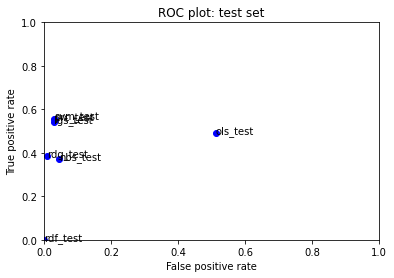

In [24]:
fits = [ols_performance_test, 
        svm_performance_test, 
        lgs_performance_test, 
        nbs_performance_test, 
        prc_performance_test, 
        rdg_performance_test, 
        rdf_performance_test
       ]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [ ]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='/home/ec2-user/data/toxiccomments_test.csv', my_random_seed=19, test=True)
print("Number of rows in the submission test set (should be 153,164): ")

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [ ]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = ols.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

In [ ]:
raw_data.head()

In [ ]:
my_submission.head()

In [ ]:
my_submission.shape

In [ ]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('/home/ec2-user/data/toxiccomments_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation